In [1]:
from pandas.tseries.offsets import BDay
import requests
from datetime import timedelta
import numpy as np
import pandas as pd

In [2]:
def fetch_data(url):
    response = requests.get(url)
    if response.status_code != 200:
        print("Error fetching data:", response.status_code, response.text)
        return None
    data = response.json()
    if 'results' not in data:
        print("No 'results' key in response:", data)
        return None
    return data

def calculate_daily_returns(df, prev_close=None):
    if prev_close is not None:
        df.loc[df.index[0], 'prev_close'] = prev_close
    else:
        df['prev_close'] = df['c'].shift(1)
    df['daily_return'] = (df['c'] - df['prev_close']) / df['prev_close']
    df['abs_daily_return'] = df['daily_return'].abs()
    return df

def get_top_outliers(df, n=10):
    return df.nlargest(n, 'abs_daily_return')

def update_outliers_list(current_df, historical_outliers_df, real_time_outliers_df, n=10):
    if 'source' not in current_df.columns:
        current_df['source'] = 'real-time'
    combined_df = pd.concat([historical_outliers_df, current_df])
    updated_outliers_df = combined_df.nlargest(n, 'abs_daily_return')
    updated_historical_outliers_df = updated_outliers_df[updated_outliers_df['source'] == 'historical']
    updated_real_time_outliers_df = updated_outliers_df[updated_outliers_df['source'] == 'real-time']
    return updated_historical_outliers_df, updated_real_time_outliers_df

def convert_timestamps(df):
    df['date'] = pd.to_datetime(df['t'], unit='ms')
    df.drop(columns=['t'], inplace=True)
    return df

# API key and endpoints
api_key = 'beBybSi8daPgsTp5yx5cHtHpYcrjp5Jq'
today = pd.Timestamp.now().date()
start_date = today - pd.DateOffset(years=1)
start_date_formatted = start_date.strftime('%Y-%m-%d')
end_date = today - pd.DateOffset(days=1)
end_date_formatted = end_date.strftime('%Y-%m-%d')
symbol = 'C:USDCHF'
historical_url = f'https://api.polygon.io/v2/aggs/ticker/{symbol}/range/1/day/{start_date_formatted}/{end_date_formatted}?adjusted=true&sort=asc&apiKey={api_key}'
real_time_url = f'https://api.polygon.io/v2/aggs/ticker/{symbol}/range/1/day/{today}/{today}?adjusted=true&sort=asc&apiKey={api_key}'

# Fetch and process historical data
historical_data = fetch_data(historical_url)
if historical_data:
    historical_df = pd.DataFrame(historical_data['results'])
    historical_df = convert_timestamps(historical_df)
    historical_df = calculate_daily_returns(historical_df)
    historical_df['source'] = 'historical'
    historical_outliers_df = get_top_outliers(historical_df)
else:
    print("Failed to fetch or process historical data.")

# Fetch and process real-time data
real_time_data = fetch_data(real_time_url)
if real_time_data and 'results' in real_time_data:
    real_time_df = pd.DataFrame(real_time_data['results'])
    real_time_df = convert_timestamps(real_time_df)
    # Use the last close from historical data
    last_close = historical_df['c'].iloc[-1] if not historical_df.empty else None
    real_time_df = calculate_daily_returns(real_time_df, prev_close=last_close)
    real_time_df['source'] = 'real-time'
    updated_historical_outliers_df, updated_real_time_outliers_df = update_outliers_list(real_time_df, historical_outliers_df, pd.DataFrame())
    # Update historical data
    historical_df = pd.concat([historical_df.iloc[1:], real_time_df])  # Keep historical data rolling
else:
    print("No new data available or failed to fetch real-time data.")
    
# Combine data for Top 10 Outliers
full_outlier_df = pd.concat([updated_historical_outliers_df, updated_real_time_outliers_df])

# Print the Outliers
full_outlier_df

,v,vw,o,c,h,l,n,date,prev_close,daily_return,abs_daily_return,source
5,193037,0.8735,0.87876,0.866590,0.87923,0.86580,193037,2023-07-12,0.87875,-0.013838,0.013838,historical
244,187960,0.8932,0.88558,0.897500,0.89937,0.88360,187960,2024-03-21,0.88555,0.013494,0.013494,historical
128,168024,0.8965,0.90127,0.889100,0.90271,0.88750,168024,2023-11-14,0.90120,-0.013427,0.013427,historical
212,191642,0.8825,0.87580,0.887420,0.88810,0.87520,191642,2024-02-13,0.87581,0.013256,0.013256,historical
171,174820,0.8495,0.85359,0.842500,0.85487,0.84060,174820,2023-12-27,0.85372,-0.013142,0.013142,historical
261,159390,0.9089,0.90297,0.913140,0.91470,0.90260,159390,2024-04-10,0.90303,0.011196,0.011196,historical
304,172177,0.9074,0.91319,0.903320,0.91408,0.90053,172177,2024-05-30,0.91311,-0.010722,0.010722,historical
203,184263,0.8610,0.85760,0.866698,0.86820,0.85510,184263,2024-02-02,0.85760,0.010609,0.010609,historical
13,181573,0.8609,0.85794,0.866230,0.86839,0.85580,181573,2023-07-20,0.85770,0.009945,0.009945,historical
278,180821,0.9142,0.91075,0.919590,0.91965,0.91020,180821,2024-04-30,0.91072,0.009740,0.009740,historical


In [3]:
sorted_outliers_data = full_outlier_df.sort_values(by="date")
sorted_outliers_data

,v,vw,o,c,h,l,n,date,prev_close,daily_return,abs_daily_return,source
5,193037,0.8735,0.87876,0.866590,0.87923,0.86580,193037,2023-07-12,0.87875,-0.013838,0.013838,historical
13,181573,0.8609,0.85794,0.866230,0.86839,0.85580,181573,2023-07-20,0.85770,0.009945,0.009945,historical
128,168024,0.8965,0.90127,0.889100,0.90271,0.88750,168024,2023-11-14,0.90120,-0.013427,0.013427,historical
171,174820,0.8495,0.85359,0.842500,0.85487,0.84060,174820,2023-12-27,0.85372,-0.013142,0.013142,historical
203,184263,0.8610,0.85760,0.866698,0.86820,0.85510,184263,2024-02-02,0.85760,0.010609,0.010609,historical
212,191642,0.8825,0.87580,0.887420,0.88810,0.87520,191642,2024-02-13,0.87581,0.013256,0.013256,historical
244,187960,0.8932,0.88558,0.897500,0.89937,0.88360,187960,2024-03-21,0.88555,0.013494,0.013494,historical
261,159390,0.9089,0.90297,0.913140,0.91470,0.90260,159390,2024-04-10,0.90303,0.011196,0.011196,historical
278,180821,0.9142,0.91075,0.919590,0.91965,0.91020,180821,2024-04-30,0.91072,0.009740,0.009740,historical
304,172177,0.9074,0.91319,0.903320,0.91408,0.90053,172177,2024-05-30,0.91311,-0.010722,0.010722,historical


In [4]:
# Convert dates in dataset to datetime objects
sorted_outliers_data['date'] = pd.to_datetime(sorted_outliers_data['date'])

date_ranges = pd.DataFrame({
    "start_date": sorted_outliers_data['date'] - BDay(3),
    "end_date": sorted_outliers_data['date'] + BDay(3),
    "outlier_date": sorted_outliers_data['date'],
})

date_ranges

,start_date,end_date,outlier_date
5,2023-07-07,2023-07-17,2023-07-12
13,2023-07-17,2023-07-25,2023-07-20
128,2023-11-09,2023-11-17,2023-11-14
171,2023-12-22,2024-01-01,2023-12-27
203,2024-01-30,2024-02-07,2024-02-02
212,2024-02-08,2024-02-16,2024-02-13
244,2024-03-18,2024-03-26,2024-03-21
261,2024-04-05,2024-04-15,2024-04-10
278,2024-04-25,2024-05-03,2024-04-30
304,2024-05-27,2024-06-04,2024-05-30


In [5]:
def calculate_daily_returns(df, prev_close=None):
    if prev_close is not None:
        df.loc[df.index[0], 'prev_close'] = prev_close
    else:
        df['prev_close'] = df['c'].shift(1)
    df['returns'] = (df['c'] - df['prev_close']) / df['prev_close']
    return df

def fetch_hourly_data_chunk(symbol, start_date, end_date, api_key):
    formatted_start_date = start_date.strftime('%Y-%m-%d')
    formatted_end_date = end_date.strftime('%Y-%m-%d')

    url = f"https://api.polygon.io/v2/aggs/ticker/{symbol}/range/1/hour/{formatted_start_date}/{formatted_end_date}?apiKey={api_key}"
    response = requests.get(url)
    
    if response.status_code != 200:
        print(f"Failed to fetch data: {response.status_code} - {response.text}")
        return None
    
    response_data = response.json()
    
    if 'results' not in response_data:
        print(f"No 'results' in response: {response_data}")
        return None

    df = pd.DataFrame(response_data['results'])
    df['date'] = pd.to_datetime(df['t'], unit='ms')
    df.drop(columns=['t'], inplace=True)
    
    return df

def fetch_and_process_hourly_data(symbol, start_date, end_date, api_key):
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_colwidth', None)
    
    # Split the date range into smaller chunks
    chunk_size = 3  # Fetch data in 7-day chunks
    date_ranges = [(start_date + timedelta(days=i*chunk_size), 
                    min(end_date, start_date + timedelta(days=(i+1)*chunk_size - 1)))
                   for i in range((end_date - start_date).days // chunk_size + 1)]

    # print((end_date - start_date).days // chunk_size + 1)
    all_data = []

    for start, end in date_ranges:
        chunk_data = fetch_hourly_data_chunk(symbol, start, end, api_key)
        if chunk_data is not None:
            all_data.append(chunk_data)
    
    if not all_data:
        print("No data fetched")
        return None
    
    df = pd.concat(all_data)
    hourly_data = calculate_daily_returns(df)
    hourly_data.set_index('date', inplace=True)
    
    full_index = pd.date_range(start=start_date, end=end_date + timedelta(days=1), freq='H')
    hourly_data = hourly_data.reindex(full_index)
    
    hourly_data.reset_index(inplace=True)
    hourly_data.rename(columns={'index': 'date'}, inplace=True)
    
    return hourly_data


In [6]:
# Initialize empty DataFrame
all_data1 = pd.DataFrame()

# Initialize an outlier identifier starting from 1 or any specific number
outlier_id = 1

for index, row in date_ranges.iterrows():
    # Convert start_date, end_date, and outlier_date to Timestamp for consistent comparison
    start_date_ts = pd.Timestamp(row['start_date'])
    end_date_ts = pd.Timestamp(row['end_date']) + pd.Timedelta(days=1)  # Extend the end date by one additional day
    outlier_date_ts = pd.Timestamp(row['outlier_date'])
    
    # Get hourly data for the range including 3 days before and after the outlier
    hourly_data = fetch_and_process_hourly_data(symbol, start_date_ts, end_date_ts, api_key)
    # print(hourly_data)
    # Check if hourly_data is not None before processing
    if hourly_data is not None:
        # Assign the current outlier_id to the data
        hourly_data['outlier_id'] = outlier_id

        # Filter out weekdends
        hourly_data = hourly_data[~hourly_data['date'].dt.weekday.isin([5,6])]
        
        # prior_data from start_date to outlier_date inclusive
        prior_data = hourly_data[(hourly_data['date'] >= start_date_ts) & (hourly_data['date'] < outlier_date_ts)]
        prior_data["day type"] = "prior day"

        # outlier_data is for the hourly data on the day of the outlier
        outlier_data = hourly_data[(hourly_data['date'].dt.date == outlier_date_ts.date())]
        outlier_data["day type"] = "outlier day"

        # post_data = hourly_data[(hourly_data['date'] > outlier_date_ts) & (hourly_data['date'] < end_date_ts)]
        # post_data["day type"] = "post day"
        
        # post_data from the day after outlier_date to end_date
        post_outlier_ts = outlier_date_ts + pd.Timedelta(days=1)  # Starting the day after the outlier_date
        post_data = hourly_data[(hourly_data['date'] > outlier_date_ts) & (hourly_data['date'] <= end_date_ts)]
        post_data["day type"] = "post day"
        # print(post_outlier_ts)
        # print(end_date_ts)
        # print(post_data)
        
        # Concatenate the data from this iteration to the cumulative DataFrame
        all_data1 = pd.concat([all_data1, prior_data, outlier_data, post_data])

        # Increment the outlier_id for the next iteration
        outlier_id += 1

    else:
        print(f"Data not available for symbol {symbol} from {row['start_date'].date()} to {row['end_date'].date()}")

# Add the day column to the final DataFrame
all_data1['day'] = all_data1['date'].dt.day_name()
# Optionally, you can reset the index of the final DataFrame if it becomes non-unique after concatenations
all_data1.reset_index(drop=True, inplace=True)

/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_85086/28904841.py:59: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_index = pd.date_range(start=start_date, end=end_date + timedelta(days=1), freq='H')
/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_85086/4232170387.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_85086/4232170387.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

                   date        v      vw         o         c         h  \
0   2023-07-07 00:00:00   5335.0  0.8959  0.895310  0.896460  0.896800   
1   2023-07-07 01:00:00   4863.0  0.8962  0.896450  0.896390  0.896520   
2   2023-07-07 02:00:00   5049.0  0.8963  0.896400  0.895920  0.896450   
3   2023-07-07 03:00:00   3826.0  0.8959  0.895900  0.896050  0.896200   
4   2023-07-07 04:00:00   5568.0  0.8959  0.896050  0.895500  0.896215   
5   2023-07-07 05:00:00   7495.0  0.8956  0.895800  0.895930  0.896000   
6   2023-07-07 06:00:00   7540.0  0.8953  0.895700  0.895480  0.895930   
7   2023-07-07 07:00:00   9453.0  0.8953  0.895500  0.895770  0.896030   
8   2023-07-07 08:00:00   9152.0  0.8959  0.895780  0.895720  0.896500   
9   2023-07-07 09:00:00  10078.0  0.8956  0.895750  0.895830  0.896300   
10  2023-07-07 10:00:00   7882.0  0.8956  0.895800  0.895100  0.896050   
11  2023-07-07 11:00:00   7795.0  0.8953  0.895270  0.895500  0.895573   
12  2023-07-07 12:00:00  14490.0  0.89

/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_85086/28904841.py:59: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_index = pd.date_range(start=start_date, end=end_date + timedelta(days=1), freq='H')
/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_85086/4232170387.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_85086/4232170387.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

                   date        v      vw         o         c         h  \
0   2023-07-17 00:00:00   4527.0  0.8618  0.861970  0.861670  0.862290   
1   2023-07-17 01:00:00   6427.0  0.8616  0.861690  0.861670  0.861900   
2   2023-07-17 02:00:00   5681.0  0.8611  0.861680  0.861000  0.861800   
3   2023-07-17 03:00:00   5517.0  0.8611  0.861010  0.861270  0.861310   
4   2023-07-17 04:00:00   5135.0  0.8613  0.861200  0.860980  0.861450   
5   2023-07-17 05:00:00   6282.0  0.8607  0.860990  0.860710  0.861100   
6   2023-07-17 06:00:00   8741.0  0.8606  0.860730  0.860200  0.861210   
7   2023-07-17 07:00:00   8826.0  0.8599  0.860190  0.859000  0.860630   
8   2023-07-17 08:00:00   7933.0  0.8588  0.859310  0.859020  0.859600   
9   2023-07-17 09:00:00   7987.0  0.8584  0.858700  0.858030  0.859080   
10  2023-07-17 10:00:00   6415.0  0.8584  0.858000  0.859040  0.859160   
11  2023-07-17 11:00:00   6600.0  0.8591  0.859030  0.859310  0.859400   
12  2023-07-17 12:00:00  10932.0  0.86

/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_85086/28904841.py:59: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_index = pd.date_range(start=start_date, end=end_date + timedelta(days=1), freq='H')
/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_85086/4232170387.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_85086/4232170387.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

                   date        v      vw         o         c         h  \
0   2023-11-09 00:00:00   2643.0  0.8994  0.899040  0.899490  0.899700   
1   2023-11-09 01:00:00   4398.0  0.8992  0.899500  0.898820  0.899700   
2   2023-11-09 02:00:00   3411.0  0.8992  0.898820  0.899400  0.899550   
3   2023-11-09 03:00:00   2448.0  0.8993  0.899420  0.899260  0.899600   
4   2023-11-09 04:00:00   2680.0  0.8992  0.899250  0.899000  0.899400   
5   2023-11-09 05:00:00   5676.0  0.8994  0.899200  0.899660  0.899820   
6   2023-11-09 06:00:00   6730.0  0.8995  0.899660  0.899400  0.900100   
7   2023-11-09 07:00:00   8285.0  0.8996  0.899430  0.899740  0.900020   
8   2023-11-09 08:00:00  10371.0  0.9001  0.899800  0.899740  0.901010   
9   2023-11-09 09:00:00  10225.0  0.8999  0.899780  0.900540  0.900910   
10  2023-11-09 10:00:00   8284.0  0.9004  0.900550  0.900580  0.900800   
11  2023-11-09 11:00:00   7857.0  0.9005  0.900400  0.900310  0.901200   
12  2023-11-09 12:00:00   8335.0  0.90

/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_85086/28904841.py:59: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_index = pd.date_range(start=start_date, end=end_date + timedelta(days=1), freq='H')
/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_85086/4232170387.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_85086/4232170387.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

                   date        v      vw         o         c         h  \
0   2023-12-22 00:00:00   4123.0  0.8560  0.856270  0.856270  0.856320   
1   2023-12-22 01:00:00   5196.0  0.8562  0.856290  0.856370  0.856450   
2   2023-12-22 02:00:00   5671.0  0.8564  0.856300  0.856510  0.856600   
3   2023-12-22 03:00:00   4300.0  0.8565  0.856520  0.856700  0.856900   
4   2023-12-22 04:00:00   3986.0  0.8567  0.856690  0.856970  0.857000   
5   2023-12-22 05:00:00   7499.0  0.8571  0.856970  0.857190  0.857400   
6   2023-12-22 06:00:00   7049.0  0.8569  0.857210  0.857020  0.857220   
7   2023-12-22 07:00:00  10466.0  0.8566  0.856700  0.856450  0.857080   
8   2023-12-22 08:00:00  11663.0  0.8560  0.856440  0.856020  0.856700   
9   2023-12-22 09:00:00  10773.0  0.8555  0.856010  0.855580  0.856010   
10  2023-12-22 10:00:00  10441.0  0.8544  0.855630  0.854540  0.855810   
11  2023-12-22 11:00:00  10604.0  0.8537  0.854300  0.853290  0.854720   
12  2023-12-22 12:00:00  11165.0  0.85

/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_85086/28904841.py:59: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_index = pd.date_range(start=start_date, end=end_date + timedelta(days=1), freq='H')
/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_85086/4232170387.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_85086/4232170387.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

                   date        v      vw         o         c         h  \
0   2024-01-30 00:00:00   5392.0  0.8613  0.861330  0.861000  0.861700   
1   2024-01-30 01:00:00   5042.0  0.8614  0.861040  0.861410  0.861800   
2   2024-01-30 02:00:00   3107.0  0.8615  0.861400  0.861440  0.861650   
3   2024-01-30 03:00:00   2961.0  0.8616  0.861450  0.861780  0.861830   
4   2024-01-30 04:00:00   3353.0  0.8617  0.861790  0.861400  0.861900   
5   2024-01-30 05:00:00   7258.0  0.8614  0.861510  0.861400  0.861700   
6   2024-01-30 06:00:00   8087.0  0.8615  0.861660  0.861800  0.862100   
7   2024-01-30 07:00:00   9847.0  0.8617  0.861980  0.861270  0.862300   
8   2024-01-30 08:00:00  12080.0  0.8624  0.861240  0.862420  0.863180   
9   2024-01-30 09:00:00   9872.0  0.8631  0.862390  0.863030  0.863910   
10  2024-01-30 10:00:00   9311.0  0.8629  0.862700  0.862600  0.863680   
11  2024-01-30 11:00:00   9269.0  0.8627  0.862650  0.862770  0.863510   
12  2024-01-30 12:00:00   8515.0  0.86

/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_85086/28904841.py:59: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_index = pd.date_range(start=start_date, end=end_date + timedelta(days=1), freq='H')
/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_85086/4232170387.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_85086/4232170387.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

                   date        v      vw        o         c         h  \
0   2024-03-18 00:00:00   1506.0  0.8835  0.88352  0.883500  0.883800   
1   2024-03-18 01:00:00   4072.0  0.8836  0.88340  0.883320  0.883900   
2   2024-03-18 02:00:00   3675.0  0.8831  0.88331  0.882900  0.883330   
3   2024-03-18 03:00:00   2997.0  0.8830  0.88290  0.883240  0.883300   
4   2024-03-18 04:00:00   2997.0  0.8833  0.88323  0.883500  0.883520   
5   2024-03-18 05:00:00   5418.0  0.8834  0.88330  0.883430  0.883600   
6   2024-03-18 06:00:00   6259.0  0.8835  0.88344  0.883770  0.883900   
7   2024-03-18 07:00:00   7505.0  0.8837  0.88376  0.883800  0.884130   
8   2024-03-18 08:00:00   8829.0  0.8837  0.88402  0.883600  0.884300   
9   2024-03-18 09:00:00   6387.0  0.8837  0.88359  0.884050  0.884180   
10  2024-03-18 10:00:00   7225.0  0.8836  0.88403  0.883100  0.884470   
11  2024-03-18 11:00:00   7411.0  0.8825  0.88280  0.882590  0.883200   
12  2024-03-18 12:00:00   8154.0  0.8831  0.88262  

/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_85086/28904841.py:59: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_index = pd.date_range(start=start_date, end=end_date + timedelta(days=1), freq='H')
/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_85086/4232170387.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_85086/4232170387.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

                   date        v      vw         o         c         h  \
0   2024-04-05 00:00:00   5712.0  0.9016  0.901510  0.901350  0.902020   
1   2024-04-05 01:00:00   5370.0  0.9018  0.901390  0.902130  0.902370   
2   2024-04-05 02:00:00   3808.0  0.9023  0.902160  0.902200  0.902580   
3   2024-04-05 03:00:00   3189.0  0.9023  0.902290  0.902200  0.902460   
4   2024-04-05 04:00:00   4987.0  0.9025  0.902330  0.902600  0.902760   
5   2024-04-05 05:00:00   5744.0  0.9023  0.902610  0.902050  0.902680   
6   2024-04-05 06:00:00   8494.0  0.9025  0.902090  0.901770  0.903440   
7   2024-04-05 07:00:00   9446.0  0.9031  0.901800  0.904130  0.904380   
8   2024-04-05 08:00:00   8247.0  0.9036  0.904100  0.903200  0.904470   
9   2024-04-05 09:00:00   7350.0  0.9032  0.903400  0.902700  0.903790   
10  2024-04-05 10:00:00   6726.0  0.9029  0.902960  0.902990  0.903300   
11  2024-04-05 11:00:00   7092.0  0.9030  0.903000  0.903450  0.903450   
12  2024-04-05 12:00:00  12760.0  0.90

/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_85086/28904841.py:59: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_index = pd.date_range(start=start_date, end=end_date + timedelta(days=1), freq='H')
/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_85086/4232170387.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_85086/4232170387.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

                   date        v      vw         o         c         h  \
0   2024-05-27 00:00:00   1719.0  0.9144  0.914200  0.914500  0.914621   
1   2024-05-27 01:00:00   2986.0  0.9144  0.914300  0.914460  0.914600   
2   2024-05-27 02:00:00   2645.0  0.9144  0.914450  0.914100  0.914602   
3   2024-05-27 03:00:00   2605.0  0.9141  0.914230  0.913900  0.914440   
4   2024-05-27 04:00:00   4837.0  0.9142  0.914230  0.914100  0.914500   
5   2024-05-27 05:00:00   5443.0  0.9142  0.914400  0.914240  0.914500   
6   2024-05-27 06:00:00   6579.0  0.9147  0.914340  0.914600  0.915100   
7   2024-05-27 07:00:00   6525.0  0.9150  0.914800  0.914800  0.915400   
8   2024-05-27 08:00:00   6735.0  0.9147  0.914900  0.914300  0.915310   
9   2024-05-27 09:00:00   6681.0  0.9140  0.914400  0.913510  0.914530   
10  2024-05-27 10:00:00   6299.0  0.9136  0.913540  0.913500  0.914050   
11  2024-05-27 11:00:00   6032.0  0.9139  0.913730  0.914300  0.914400   
12  2024-05-27 12:00:00   8449.0  0.91

/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_85086/28904841.py:59: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_index = pd.date_range(start=start_date, end=end_date + timedelta(days=1), freq='H')
/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_85086/4232170387.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_85086/4232170387.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

In [7]:
all_data1

,date,v,vw,o,c,h,l,n,prev_close,returns,outlier_id,day type,day
0,2023-07-07 00:00:00,5335.0,0.8959,0.895310,0.896460,0.896800,0.895000,5335.0,NaN,NaN,1,prior day,Friday
1,2023-07-07 01:00:00,4863.0,0.8962,0.896450,0.896390,0.896520,0.895800,4863.0,0.896460,-0.000078,1,prior day,Friday
2,2023-07-07 02:00:00,5049.0,0.8963,0.896400,0.895920,0.896450,0.895700,5049.0,0.896390,-0.000524,1,prior day,Friday
3,2023-07-07 03:00:00,3826.0,0.8959,0.895900,0.896050,0.896200,0.895300,3826.0,0.895920,0.000145,1,prior day,Friday
4,2023-07-07 04:00:00,5568.0,0.8959,0.896050,0.895500,0.896215,0.895200,5568.0,0.896050,-0.000614,1,prior day,Friday
5,2023-07-07 05:00:00,7495.0,0.8956,0.895800,0.895930,0.896000,0.895070,7495.0,0.895500,0.000480,1,prior day,Friday
6,2023-07-07 06:00:00,7540.0,0.8953,0.895700,0.895480,0.895930,0.894700,7540.0,0.895930,-0.000502,1,prior day,Friday
7,2023-07-07 07:00:00,9453.0,0.8953,0.895500,0.895770,0.896030,0.894500,9453.0,0.895480,0.000324,1,prior day,Friday
8,2023-07-07 08:00:00,9152.0,0.8959,0.895780,0.895720,0.896500,0.895200,9152.0,0.895770,-0.000056,1,prior day,Friday
9,2023-07-07 09:00:00,10078.0,0.8956,0.895750,0.895830,0.896300,0.894700,10078.0,0.895720,0.000123,1,prior day,Friday


In [16]:
def dtw_distance(series1, series2):
    n, m = len(series1), len(series2)
    dtw_matrix = np.zeros((n+1, m+1))
    
    for i in range(n+1):
        for j in range(m+1):
            dtw_matrix[i, j] = np.inf
    dtw_matrix[0, 0] = 0
    
    for i in range(1, n+1):
        for j in range(1, m+1):
            cost = abs(series1[i-1] - series2[j-1])
            # Take last min from a square sub-matrix
            last_min = np.min([dtw_matrix[i-1, j], dtw_matrix[i, j-1], dtw_matrix[i-1, j-1]])
            dtw_matrix[i, j] = cost + last_min
            
    return dtw_matrix[n, m]

# Load your data
data = pd.read_csv('USDCHF_hourly.csv')
# Fill null values with ffill then bfill to ensure all nulls are handled
data.fillna(method='ffill', inplace=True)
data.fillna(method='bfill', inplace=True)
all_data1.fillna(method='ffill', inplace=True)
all_data1.fillna(method='bfill', inplace=True)

# Filter Prior Day Data
prior_day_data = data[data['day type'] == 'prior day']

# # Main series to compare others against
main = all_data1[all_data1['day type'] == 'prior day']
ts_main_id = main[main['outlier_id'] == 10]['c'].values

# Calculate DTW distances between the current outlier's series and each of the other outliers
dtw_distances = {}
for id in prior_day_data["outlier_id"].unique():
    series = prior_day_data[prior_day_data['outlier_id'] == id]['c'].values
    distance = dtw_distance(ts_main_id, series)
    dtw_distances[id] = distance

# Sort the distances and get the top 10 lowest
top_10_ids = sorted(dtw_distances, key=dtw_distances.get)[:10]

# Output the results
for id in top_10_ids:
    print(f"DTW Distance between Current Outlier and ID {id}: {dtw_distances[id]:.2f}")

/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_85086/4012235278.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)
/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_85086/4012235278.py:23: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill', inplace=True)
/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_85086/4012235278.py:24: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  all_data1.fillna(method='ffill', inplace=True)
/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_85086/4012235278.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfil

DTW Distance between Current Outlier and ID 131: 0.83
DTW Distance between Current Outlier and ID 132: 1.15
DTW Distance between Current Outlier and ID 111: 1.27
DTW Distance between Current Outlier and ID 133: 1.42
DTW Distance between Current Outlier and ID 134: 1.42
DTW Distance between Current Outlier and ID 112: 1.54
DTW Distance between Current Outlier and ID 140: 1.67
DTW Distance between Current Outlier and ID 135: 1.68
DTW Distance between Current Outlier and ID 113: 1.79
DTW Distance between Current Outlier and ID 114: 1.79


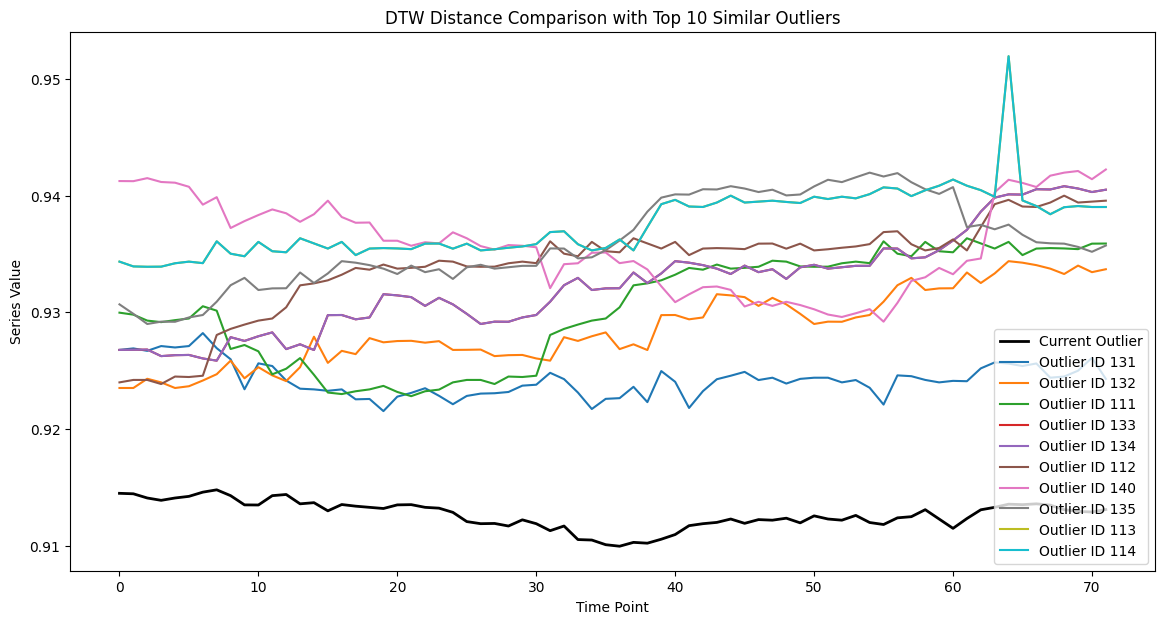

In [17]:
import matplotlib.pyplot as plt

# Prepare the plot
plt.figure(figsize=(14, 7))
plt.plot(ts_main_id, label='Current Outlier', linewidth=2, color='black')

# Plot each series in the top 10
for id in top_10_ids:
    series = prior_day_data[prior_day_data['outlier_id'] == id]['c'].values
    plt.plot(series, label=f'Outlier ID {id}')

plt.title('DTW Distance Comparison with Top 10 Similar Outliers')
plt.xlabel('Time Point')
plt.ylabel('Series Value')
plt.legend()
plt.show()